In [3]:

# def extract_resnet_features(framedata, cross=True):
#     model = models.resnet50(pretrained=True)
#     model.fc = torch.nn.Identity()  # remove final classification layer
#     model = model.to(device)
#     model.eval()

#     preprocess = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#     ])

#     all_features = []

#     with torch.no_grad():
#         for frame in tqdm(framedata, desc="Extracting ResNet50 features"):
#             img_np = screen_setup.preprocess_image(frame, cross=cross)
#             img_t = preprocess(np.uint8(img_np)).unsqueeze(0).to(device)
#             feats = model(img_t).cpu().numpy().squeeze()
#             all_features.append(feats)

#     return np.stack(all_features)

Processing MIT001_20251021-161314
Extracting CLIP features for MIT001_20251021-161314


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Extracting CLIP features: 100%|██████████| 480/480 [00:26<00:00, 17.95it/s]
/Users/fullguest/Desktop/seeg_rsvp/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fullguest/Desktop/seeg_rsvp/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=

Extracting ResNet50 features for MIT001_20251021-161314
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/fullguest/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:06<00:00, 15.2MB/s]
Extracting ResNet50 features: 100%|██████████| 480/480 [00:19<00:00, 24.20it/s]


Processing MIT001_20251021-162302
Extracting CLIP features for MIT001_20251021-162302


Extracting CLIP features: 100%|██████████| 480/480 [00:26<00:00, 18.11it/s]


Extracting ResNet50 features for MIT001_20251021-162302


Extracting ResNet50 features: 100%|██████████| 480/480 [00:21<00:00, 22.31it/s]


Processing MIT001_20251021-160957
Extracting CLIP features for MIT001_20251021-160957


Extracting CLIP features: 100%|██████████| 50/50 [00:02<00:00, 17.97it/s]


Extracting ResNet50 features for MIT001_20251021-160957


Extracting ResNet50 features: 100%|██████████| 50/50 [00:01<00:00, 25.58it/s]


Processing MIT001_20251021-163219
Extracting CLIP features for MIT001_20251021-163219


Extracting CLIP features: 100%|██████████| 480/480 [00:27<00:00, 17.35it/s]


Extracting ResNet50 features for MIT001_20251021-163219


Extracting ResNet50 features: 100%|██████████| 480/480 [00:20<00:00, 22.96it/s]


In [5]:
import os
import json
import torch
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from abc import ABC, abstractmethod
from transformers import AutoProcessor, AutoModel, CLIPModel

import screen_setup  # your preprocessing

device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
#  Base Abstract Class
# ============================================================
class FeatureExtractor(ABC):
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.model = None
        self.processor = None
        self.load_model()

    @abstractmethod
    def load_model(self):
        pass

    @abstractmethod
    def extract_features(self, img_np):
        pass

    def process_partial(self, framedata, cross=True):
        """Extract features for a batch of frames (no stacking)."""
        self.model.eval()
        features = []

        with torch.no_grad():
            for frame in tqdm(framedata, desc=f"Extracting {self.model_name} features (partial)", leave=False):
                img_np = screen_setup.preprocess_image(frame, cross=cross)
                # convert from BGR to RGB
                img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

                feat = self.extract_features(img_np)
                features.append(feat)

        return np.stack(features)


# ============================================================
#  Generic Hugging Face Vision Model Extractor
# ============================================================
class HFVisionFeatureExtractor(FeatureExtractor):
    def load_model(self):
        print(f"Loading model: {self.model_name}")
        self.processor = AutoProcessor.from_pretrained(self.model_name)

        self.model = AutoModel.from_pretrained(self.model_name).to(device)

    def extract_features(self, img_np):
        img_pil = Image.fromarray(np.uint8(img_np))
        inputs = self.processor(images=img_pil, return_tensors="pt").to(device)

        if "clip" in self.model_name.lower():
            feats = self.model.get_image_features(pixel_values=inputs["pixel_values"])
        else:
            outputs = self.model(**inputs)

            if hasattr(outputs, "image_embeds"):
                feats = outputs.image_embeds
            # Handle pure vision encoders (ViT, DINO, ConvNeXt)
            elif hasattr(outputs, "pooler_output"):
                feats = outputs.pooler_output
            elif hasattr(outputs, "last_hidden_state"):
                feats = outputs.last_hidden_state.mean(dim=1)
            else:
                raise ValueError(f"Unsupported output type for model: {self.model_name}")

        feats = feats / feats.norm(p=2, dim=-1, keepdim=True)
        return feats.cpu().numpy().squeeze()



# ============================================================
#  Main Pipeline (chunked feature extraction)
# ============================================================
def process_imagebank(model_names, imagebank_root="imagebank/", chunk_size=5000):
    extractors = [HFVisionFeatureExtractor(name) for name in model_names]

    imagebank_dirs = [
        d for d in os.listdir(imagebank_root)
        if os.path.isdir(os.path.join(imagebank_root, d))
    ]

    for imagebank_dir in imagebank_dirs:
        print(f"\n📁 Processing: {imagebank_dir}")
        path_json = os.path.join(imagebank_root, imagebank_dir, "framedata.json")
        if not os.path.exists(path_json):
            path_json = os.path.join(imagebank_root, imagebank_dir, "template.json")

        with open(path_json, "r") as f:
            framedata = json.load(f)['framedata']

        # Remove all repeats
        unique_paths = set()
        unique_framedata = []
        for frame in framedata:
            if frame['image_path'] not in unique_paths:
                unique_paths.add(frame['image_path'])
                unique_framedata.append(frame)
        framedata = unique_framedata
        # Save the current framedata as framedata_features.json in the appropriate imagebank_dir
        framwdata_features_path = os.path.join(imagebank_root, imagebank_dir, "framedata_features.json")
        with open(framwdata_features_path, "w") as f_out:
            json.dump({"framedata": framedata}, f_out, indent=2)

        for extractor in extractors:
            # sanitize name for filesystem
            safe_name = extractor.model_name.replace("/", "_")
            save_path = os.path.join(imagebank_root, imagebank_dir, f"features_{safe_name}.npy")
            if os.path.exists(save_path):
                print(f"→ Skipping {extractor.model_name} features for {imagebank_dir} because they already exist")
                continue

            # Chunked saving
            print(f"→ Extracting {extractor.model_name} features in chunks of {chunk_size} ...")
            n_images = len(framedata)
            part_paths = []
            for part_idx, start_idx in enumerate(range(0, n_images, chunk_size)):
                partpath = os.path.join(imagebank_root, imagebank_dir, f"features_{safe_name}_part{part_idx+1}.npy")
                if os.path.exists(partpath):
                    print(f"→ Skipping {extractor.model_name} features for {imagebank_dir} because they already exist")
                    continue
                end_idx = min(start_idx + chunk_size, n_images)
                feats = extractor.process_partial(framedata[start_idx:end_idx])
                np.save(partpath, feats)
                part_paths.append(partpath)
                print(f"    Saved chunk {part_idx+1} [{start_idx}:{end_idx}] to {partpath}")
                
            # Combine
            print(f"→ Combining {len(part_paths)} parts into one final npy...")
            all_parts = [np.load(pp) for pp in part_paths]
            full_feats = np.concatenate(all_parts)
            np.save(save_path, full_feats)
            print(f"✅ Saved combined: {save_path}")

            # Clean up part files
            for pp in part_paths:
                os.remove(pp)

model_list = [
    "openai/clip-vit-base-patch32",
    # "facebook/dino-vits16",
    # "google/vit-base-patch16-224",
]
process_imagebank(model_list)


Loading model: openai/clip-vit-base-patch32

📁 Processing: first_n480_on100_off150_s2
→ Skipping openai/clip-vit-base-patch32 features for first_n480_on100_off150_s2 because they already exist

📁 Processing: first_n480_on100_off150_s3
→ Skipping openai/clip-vit-base-patch32 features for first_n480_on100_off150_s3 because they already exist

📁 Processing: ILSVRC2012_img_val
→ Skipping openai/clip-vit-base-patch32 features for ILSVRC2012_img_val because they already exist

📁 Processing: OASIS
→ Skipping openai/clip-vit-base-patch32 features for OASIS because they already exist

📁 Processing: trial_s1_n480_x4_on100-100_off125-175
→ Extracting openai/clip-vit-base-patch32 features in chunks of 5000 ...


    Saved chunk 1 [0:480] to imagebank/trial_s1_n480_x4_on100-100_off125-175\features_openai_clip-vit-base-patch32_part1.npy
→ Combining 1 parts into one final npy...
✅ Saved combined: imagebank/trial_s1_n480_x4_on100-100_off125-175\features_openai_clip-vit-base-patch32.npy

📁 Processing: trial_s2_n480_x4_on100-100_off125-175
→ Extracting openai/clip-vit-base-patch32 features in chunks of 5000 ...


    Saved chunk 1 [0:480] to imagebank/trial_s2_n480_x4_on100-100_off125-175\features_openai_clip-vit-base-patch32_part1.npy
→ Combining 1 parts into one final npy...
✅ Saved combined: imagebank/trial_s2_n480_x4_on100-100_off125-175\features_openai_clip-vit-base-patch32.npy


## Show Example Images

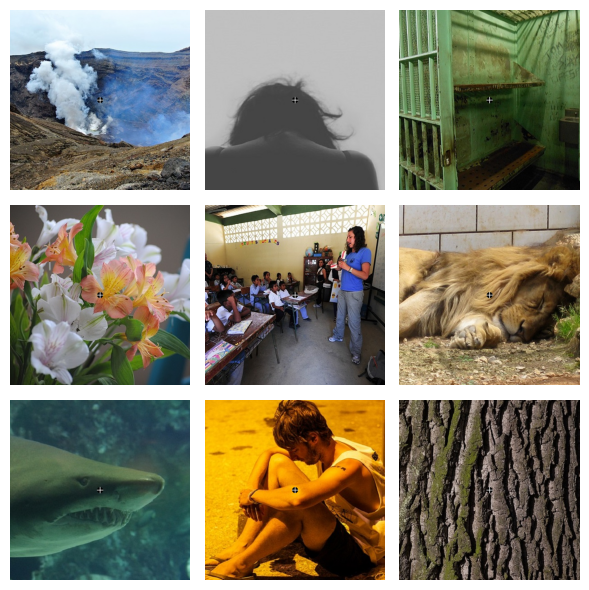

In [23]:
framedata_datasets = np.array([frame['dataset'] for frame in framedata])
framedata_unique_datasets = list(set(framedata_datasets))
framedata_unique_dataset_indices = []
for dataset in framedata_unique_datasets:
    framedata_dataset_indices = np.where(framedata_datasets == dataset)[0]
    framedata_unique_dataset_indices.append(framedata_dataset_indices)

dataset_id = 2
images = []
n_show_images = 9
for fdi in framedata_unique_dataset_indices[dataset_id][:n_show_images]:
    frame = framedata[fdi]
    images.append(cv2.cvtColor(screen_setup.preprocess_image(frame, cross=True), cv2.COLOR_RGB2BGR))

n_cols = 3
n_rows = int(np.ceil(n_show_images / n_cols))
import matplotlib.pyplot as plt
# make a grid of the images
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()





Removed 55 target trials, left 425 non-target trials


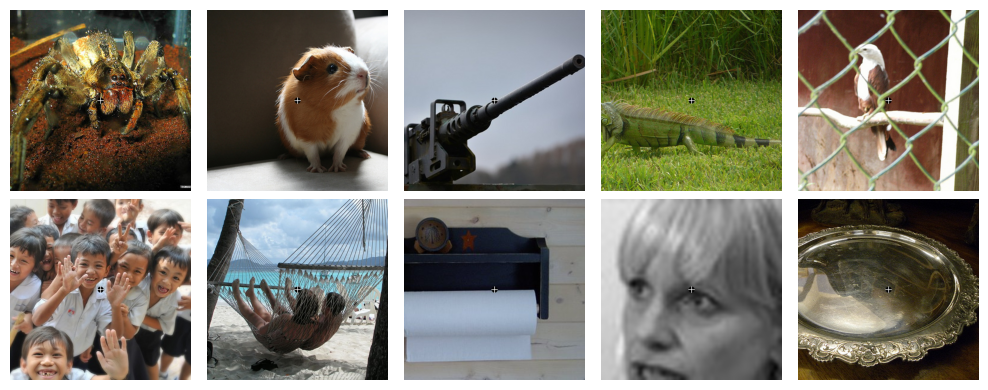

In [10]:
actual_lowest_act_id = [128, 336,  33, 295, 357]
actual_highest_act_id = [131, 213, 298, 148, 370]
all_id = actual_lowest_act_id + actual_highest_act_id

with open("imagebank/MIT001_20251021-162302/framedata.json", "r") as f:
    framedata = json.load(f)

not_target = ~np.array([f['target'] for f in framedata])
not_target_idx = np.where(not_target)[0]
framedata = [framedata[i] for i in not_target_idx]

print(f"Removed {np.sum(~not_target)} target trials, left {len(framedata)} non-target trials")

dataset_id = 2
images = []
for fdi in all_id:
    frame = framedata[fdi]
    images.append(cv2.cvtColor(screen_setup.preprocess_image(frame, cross=True), cv2.COLOR_RGB2BGR))

n_cols = 5
n_rows = int(np.ceil(len(images) / n_cols))
import matplotlib.pyplot as plt
# make a grid of the images
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

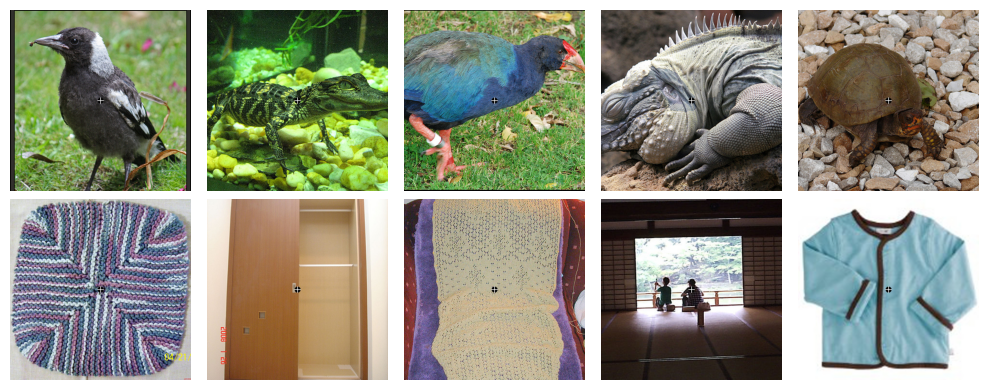

In [11]:
predicted_lowest_id = [2226, 3892, 3005, 4083, 4262]
predicted_highest_id = [1452, 1804, 4111, 3097, 3295]
all_id = predicted_lowest_id + predicted_highest_id

with open("imagebank/ILSVRC2012_img_val/framedata.json", "r") as f:
    framedata = json.load(f)

dataset_id = 2
images = []
for fdi in all_id:
    frame = framedata[fdi]
    images.append(cv2.cvtColor(screen_setup.preprocess_image(frame, cross=True), cv2.COLOR_RGB2BGR))

n_cols = 5
n_rows = int(np.ceil(len(images) / n_cols))
import matplotlib.pyplot as plt
# make a grid of the images
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()